In [1]:
from openai import OpenAI
import matplotlib as plt
from PIL import Image
import base64
import requests
import os
import pandas as pd
import numpy as np
import json
from io import BytesIO
import time

import dotenv
dotenv.load_dotenv('../.env')
api_key = os.getenv('OPENAI')

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

client = OpenAI(api_key = api_key)

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff

In [2]:
city = "London"
cityabbr = city.replace(" ", "").lower()
folder = "./data/gsv_rgb"
META_FILE = "{city}_meta.csv"

IMG_FILE = f'img_encoding_{city}_5k.parquet'
# yeargroup0 = [2016, 2017]
yeargroup1 = [2015, 2016, 2017]
yeargroup2 = [2021, 2022, 2023]

dist_thred = 5500
meta_folder = "gsvmeta"

# let's only take angle = 0 for now
ANGLE = 0

metafiles = os.listdir(os.path.join(folder, cityabbr, meta_folder))
img_file = IMG_FILE.format(city=city)
img_file_path = os.path.join(folder, cityabbr, meta_folder, img_file)
df = pd.read_parquet(img_file_path)

In [3]:
resultfolder = os.path.join(folder, cityabbr, "comp_results")
if not os.path.exists(resultfolder):
    os.makedirs(resultfolder)
    
curatefolder = os.path.join(folder, cityabbr, "curate")
if not os.path.exists(curatefolder):
    os.makedirs(curatefolder)

In [4]:
df_sel = df[(df.year.isin(yeargroup1+yeargroup2)) & (df.dist_hav < dist_thred)].reset_index(drop = True)
df_sel['year_group'] = np.where(df_sel['year'].isin(yeargroup1), 'A', 'B')
df_sel_angle = df_sel.groupby(['h3_res12', 'year_group','angle']).first().reset_index()[[
    'h3_res12','year', 'panoid','img_encoding', 'year_group','lat','lon','angle']]
df_sel_angle['num_panoids'] = df_sel_angle.groupby(['h3_res12','angle'])['panoid'].transform('nunique')
df_sel_angle = df_sel_angle[df_sel_angle['num_panoids'] > 1].reset_index(drop = True)

In [5]:
print(df_sel_angle['h3_res12'].nunique()) # 1876

1876


<Axes: >

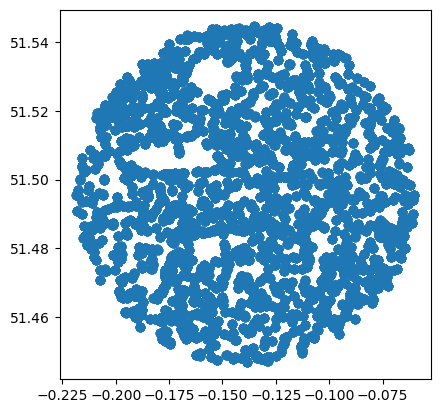

In [80]:
import geopandas as gpd
df_sel_angle = gpd.GeoDataFrame(df_sel_angle, geometry=gpd.points_from_xy(df_sel_angle.lon, df_sel_angle.lat), crs="EPSG:4326")
df_sel_angle.plot()

In [124]:
# df_sel_angle[['lat','lon','panoid']].drop_duplicates().to_csv('testing_london.csv', index = False)

# Start build on gpt

In [125]:
system_message ="""
    You will be provided with a pair of images: the first image is labeled as A and the second image is labeled as B. \
    The images are taken from the same location but at different years. \
    You should ignore the impact of weather, lighting, and other environmental factors. \
    Provider your output in json format with the keys: 
    tree, tree-overgrown, grass, sidewalk, building-renew, building, graffiti, painting, trash, crosswalk, furniture, bikelane, road, and construction.
    
    Each object has the following format:
        'tree': <answer to the question Which side of the two images has more trees coverage?>
    AND 
        'tree-overgrown': <answer to the question Which side of the two images has trees overgrown and lack maintenance?>
    AND 
        'grass': <answer to the question Which side of the two images has more grasses?>
    AND
        'sidewalk': <answer to the question Which side of the two images has new or more paved sidewalk?>
    AND
        'building-renew': <answer to the question Which side of the two images has renewed building?>
    AND
        'building': <answer to the question Which side of the two images has added new building?>
    AND 
        'graffiti': <answer to the question Which side of the two images has dirty graffiti?>
    AND 
        'painting': <answer to the question Which side of the two images has painting on the wall?>
    AND 
        'trash': <answer to the question Which side of the two images has more trash?>
    AND 
        'crosswalk': <answer to the question Which side of the two images has crosswalk?>
    AND
        'furniture': <answer to the question Which side of the two images has more furniture?>
    AND
        'bikelane': <answer to the question Which side of the two images has bikelane?>
    AND 
        'road': <answer to the question Which side of the two images has road surface that looks newer?>
    AND 
        'construction': <answer to the question Which side of the two images has ongoing constructions that block the view or road?>


    Where the answer must be one of the following: `A`, `B`, `both`,`none`.
    """

In [6]:
test = "Address (House # and Street Name)"
test.lower().replace("(", "").replace(")", "").replace("# ", "").replace(" ", "_").strip()

'address_house_and_street_name'

In [142]:
def get_param(df_sel_angle, sample_h3):
    base64_image_A = df_sel_angle[(df_sel_angle['h3_res12']==sample_h3)&(df_sel_angle['year_group']=='A')\
        &(df_sel_angle['angle']==0)]['img_encoding'].values[0]
    panoid_A = df_sel_angle[(df_sel_angle['h3_res12']==sample_h3)&(df_sel_angle['year_group']=='A')\
        &(df_sel_angle['angle']==0)]['panoid'].values[0]
    base64_image_B = df_sel_angle[(df_sel_angle['h3_res12']==sample_h3)&(df_sel_angle['year_group']=='B')\
        &(df_sel_angle['angle']==0)]['img_encoding'].values[0]
    panoid_B = df_sel_angle[(df_sel_angle['h3_res12']==sample_h3)&(df_sel_angle['year_group']=='B')\
        &(df_sel_angle['angle']==0)]['panoid'].values[0]
    return base64_image_A, panoid_A, base64_image_B, panoid_B

def construct_message(base64_image_A, base64_image_B, system_message):
    messages = [
    {
        'role': 'system',
        'content': system_message},
    {'role':'user',
     'content':[
         {
             "type": "image_url",
             "image_url": {
                 "url": f"data:image/jpeg;base64,{base64_image_A}",
                 "detail": "low"
             }
          },
         {
             "type": "image_url",
             "image_url": {
                 "url": f"data:image/jpeg;base64,{base64_image_B}",
                 "detail": "low"
             }
          }
     ],
    }
]
    return messages

In [195]:
# save the result to datafame format
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def get_comparison_result(df_sel_angle_current, sample_h3, angle = ANGLE, system_message = system_message):
    base64_image_A, panoid_A, base64_image_B, panoid_B = get_param(df_sel_angle_current, sample_h3)
    messages = construct_message(base64_image_A, base64_image_B, system_message)
    try:
        response = client.chat.completions.create(
            model="gpt-4-vision-preview",
            messages = messages,
            temperature = 0,
            max_tokens = 500,
        )
    # check response
    # if response.choices[0].message.content.startswith("```json"):
        
        result = json.loads(response.choices[0].message.content.replace("```json", "").replace("```", ""))
        result['angle'] = angle
        result['A'] = panoid_A
        result['B'] = panoid_B
        return result
    except Exception as e:
        print(e)
        # sleep for a while
        time.sleep(1800)
        print("sleep for 30 minutes")
        # retry
        return get_comparison_result(df_sel_angle_current, sample_h3, angle, system_message)


In [144]:
# DEBUGGING
# df_sel_angle_current = df_sel_angle[df_sel_angle['angle'] == ANGLE].reset_index(drop = True)
# h3_ls = df_sel_angle_current['h3_res12'].unique()
# sample_h3 = h3_ls[0]
# result = get_comparison_result(df_sel_angle_current, sample_h3)
# result_df = []
# result_df.append(result)
# result_df = pd.DataFrame(result_df)
# result_df

{'tree': 'B',
 'tree-overgrown': 'none',
 'grass': 'A',
 'sidewalk': 'none',
 'building-renew': 'none',
 'building': 'none',
 'graffiti': 'none',
 'painting': 'none',
 'trash': 'none',
 'crosswalk': 'none',
 'furniture': 'none',
 'bikelane': 'none',
 'road': 'B',
 'construction': 'none',
 'angle': 0,
 'A': '20i2R-uMmBi2aiwZQstz0w',
 'B': '-cYQHu8nOZpxEXj9yYSYOQ'}

In [154]:
# cost estimates: input + output
inputcost = 0.00085*2*len(h3_ls)
outputcost = 0.00006*len(h3_ls)
totalcost = inputcost + outputcost
print(f"Total cost: {totalcost} for {len(h3_ls)} comparisons")
# estimated time
estimated_time = 2*len(h3_ls)/3600
print(f"Estimated time: {estimated_time} hour for {len(h3_ls)} comparisons")


Total cost: 3.3017600000000003 for 1876 comparisons
Estimated time: 1.0422222222222222 hour for 1876 comparisons


In [145]:
# base64_image_A, panoid_A, base64_image_B, panoid_B = get_param(df_sel_angle_current, sample_h3)

In [ ]:
# innitiation
import time
start = time.time()
print("Start time: ", start)

from tqdm import tqdm
result_df = []

In [172]:
# read finished results
finished = os.listdir(resultfolder)
df_finish = pd.read_csv(os.path.join(resultfolder, finished[-1]))
df_finish

,tree,tree-overgrown,grass,sidewalk,building-renew,building,graffiti,painting,trash,crosswalk,furniture,bikelane,road,construction,angle,A,B
0,B,none,B,none,none,none,none,none,none,none,none,none,none,none,0,20i2R-uMmBi2aiwZQstz0w,-cYQHu8nOZpxEXj9yYSYOQ
1,B,none,none,none,none,none,none,none,none,none,none,none,none,none,0,tMlGDH6WA_5JIMOPw-Pwcw,5_EAPBGGKNE09apAIXuxOQ
2,B,A,B,none,none,none,none,none,none,none,none,both,B,none,0,iRdJX3Kr3UW4jfU04RRNQA,WKNQrycQfrlXzktNCgm1iQ
3,B,A,B,none,none,none,none,none,none,none,none,none,B,none,0,Hs9i8X0HWqXVzzwq7UO7vQ,zc2_cSWaEAZxn7CgD-QIEg
4,B,none,A,both,none,none,none,none,none,none,none,none,B,none,0,tSm4aYT-an0oDH9-vHb6-g,tZBjPjTX89hmIZ38PCXaQQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,none,none,none,B,none,none,none,none,none,none,none,none,B,none,0,NmexB1PqxZMHs_BJ3pS7mA,2ErhqdpwIhsUC87YSkAbEg
517,none,none,none,none,none,none,none,none,none,none,none,none,none,none,0,h14pmg0MCamJiPIJkVYwLQ,Tc8IwxyV-9lPsfQ_i50x3Q
518,both,none,both,none,none,none,none,none,none,none,none,both,none,none,0,pAafdlQG6vbs4x0AHSeHlQ,IHGlKqgX74qo5j1AGOxRoQ
519,both,none,both,none,none,none,none,none,none,none,A,both,none,none,0,I6HZuaofCWWxpYdcmgALuw,8I6kp7CRt_za-aMtLc1fTA


In [210]:

for sample_h3 in tqdm(h3_ls[975:]):
    result = get_comparison_result(df_sel_angle_current, sample_h3)
    result_df.append(result)
    time.sleep(5)
    n = len(result_df)
    if n % 50 == 0:
        df_result = pd.DataFrame(result_df)
        df_result.to_csv(os.path.join(resultfolder, f"angle_{ANGLE}_row{n}.csv"), index = False)
        print(f"Saved {n} samples")
df_result = pd.DataFrame(result_df)
df_result.to_csv(os.path.join(resultfolder, f"angle_{ANGLE}_last.csv"), index = False)
print(f"Saved {n} samples")
print("Finished")
end = time.time()

  3%|▎         | 25/901 [05:10<2:50:21, 11.67s/it]

Saved 1000 samples


  8%|▊         | 75/901 [15:17<2:51:42, 12.47s/it]

Saved 1050 samples


 14%|█▍        | 125/901 [24:59<2:34:09, 11.92s/it]

Saved 1100 samples


 19%|█▉        | 175/901 [34:26<2:34:53, 12.80s/it]

Saved 1150 samples


 25%|██▍       | 225/901 [44:24<2:00:56, 10.74s/it]

Saved 1200 samples


 31%|███       | 275/901 [53:45<1:43:05,  9.88s/it]

Saved 1250 samples


 36%|███▌      | 325/901 [1:03:13<1:49:02, 11.36s/it]

Saved 1300 samples
Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 39%|███▊      | 349/901 [1:38:05<1:58:57, 12.93s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 41%|████▏     | 373/901 [2:12:50<1:42:58, 11.70s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 42%|████▏     | 375/901 [2:43:25<57:22:11, 392.64s/it]

Saved 1350 samples


 44%|████▍     | 397/901 [2:47:44<1:27:21, 10.40s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 47%|████▋     | 422/901 [3:22:55<1:35:51, 12.01s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 47%|████▋     | 425/901 [3:53:31<36:32:37, 276.38s/it]

Saved 1400 samples


 50%|████▉     | 446/901 [3:57:38<1:22:04, 10.82s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 52%|█████▏    | 470/901 [4:32:21<1:14:29, 10.37s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 52%|█████▏    | 472/901 [5:02:51<46:30:15, 390.25s/it]

Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'sanitizer_server_error'}}
sleep for 30 minutes


 53%|█████▎    | 475/901 [5:33:30<48:05:49, 406.45s/it]

Saved 1450 samples


 57%|█████▋    | 517/901 [5:41:11<1:04:56, 10.15s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 58%|█████▊    | 525/901 [6:12:59<5:53:08, 56.35s/it]  

Saved 1500 samples


 60%|██████    | 541/901 [6:16:00<1:15:51, 12.64s/it]

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 63%|██████▎   | 565/901 [6:50:36<58:45, 10.49s/it]    

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 64%|██████▍   | 575/901 [7:22:41<2:58:12, 32.80s/it]  

Saved 1550 samples


 65%|██████▌   | 589/901 [7:25:31<1:03:49, 12.27s/it]

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 67%|██████▋   | 608/901 [7:59:26<56:39, 11.60s/it]    

Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'sanitizer_server_error'}}
sleep for 30 minutes


 69%|██████▉   | 625/901 [8:32:33<1:03:54, 13.89s/it]  

Saved 1600 samples


 71%|███████   | 636/901 [8:34:37<49:29, 11.20s/it]  

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 73%|███████▎  | 660/901 [9:09:01<42:36, 10.61s/it]    

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 75%|███████▍  | 675/901 [9:41:46<52:48, 14.02s/it]    

Saved 1650 samples


 76%|███████▌  | 684/901 [9:43:23<40:14, 11.13s/it]

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 79%|███████▊  | 708/901 [10:18:00<36:12, 11.26s/it]    

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 80%|████████  | 725/901 [10:51:23<42:37, 14.53s/it]    

Saved 1700 samples


 81%|████████  | 732/901 [10:52:39<30:47, 10.93s/it]

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes
Request timed out.
sleep for 30 minutes


 86%|████████▌ | 775/901 [12:01:26<26:05, 12.42s/it]     

Saved 1750 samples


 86%|████████▋ | 779/901 [12:02:12<23:17, 11.45s/it]

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 89%|████████▉ | 802/901 [12:36:53<18:23, 11.15s/it]    

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 92%|█████████▏| 825/901 [13:11:22<13:45, 10.86s/it]    

Saved 1800 samples


 92%|█████████▏| 827/901 [13:11:54<16:18, 13.22s/it]

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 94%|█████████▍| 851/901 [13:46:27<08:42, 10.44s/it]    

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


 97%|█████████▋| 875/901 [14:21:16<04:47, 11.06s/it]   

Saved 1850 samples
Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


100%|█████████▉| 899/901 [14:56:07<00:24, 12.12s/it]   

Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-vision-preview in organization org-0cVOieZa4EPLW8ppay7ljGZr on requests per day (RPD): Limit 1000, Used 1000, Requested 1. Please try again in 1m26.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
sleep for 30 minutes


100%|██████████| 901/901 [15:26:34<00:00, 61.70s/it] 

Saved 1876 samples
Finished


In [198]:
# df_result = pd.DataFrame(result_df)
# # df_result
# df_result.to_csv(os.path.join(resultfolder, f"angle_{ANGLE}_row{n}.csv"), index = False)

# Visualize the current result

In [212]:
df_viz = df_result.merge(df_sel_angle[['panoid', 'lat', 'lon']].drop_duplicates(),
                left_on = 'A', right_on = 'panoid', how = 'left').merge(
                df_sel_angle[['panoid', 'lat', 'lon']].drop_duplicates(),
                left_on = 'B', right_on = 'panoid', how = 'left',
                suffixes = ('_A', '_B')).drop(columns = ['panoid_A', 'panoid_B'])
df_viz['center_lat'] = (df_viz['lat_A'] + df_viz['lat_B'])/2
df_viz['center_lon'] = (df_viz['lon_A'] + df_viz['lon_B'])/2
df_viz.to_csv(os.path.join(curatefolder, f"angle_{ANGLE}_viz.csv"), index = False)

In [201]:
# for all categories, if there is a B, then it is an improvement, if there is an A, then it is a decline
# when it is improved, we add 1, when it is declined, we keep it as -1, when it is either none or both, we keep it as 0
df_result.columns
improve_fields = ['tree',  'grass', 'sidewalk', 'building-renew',
       'building',  'painting',  'crosswalk', 'furniture',
       'bikelane', 'road', ]
decline_fields = ['tree-overgrown', 'graffiti', 'trash', 'construction']
viz = df_result.copy()
# valuemap = {'A':-1, 'B':1, 'both':0, 'none':0}
# for field in fields:
#     viz[field] = viz[field].map(valuemap)
# viz.head()
# merge the latitude and longitude back to the dataframe
df_sel_angle = df_sel_angle.drop(columns = ['geometry'])

,tree,tree-overgrown,grass,sidewalk,building-renew,building,graffiti,painting,trash,crosswalk,furniture,bikelane,road,construction,angle,A,B
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,20i2R-uMmBi2aiwZQstz0w,-cYQHu8nOZpxEXj9yYSYOQ
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tMlGDH6WA_5JIMOPw-Pwcw,5_EAPBGGKNE09apAIXuxOQ
2,1,-1,1,0,0,0,0,0,0,0,0,0,1,0,0,iRdJX3Kr3UW4jfU04RRNQA,WKNQrycQfrlXzktNCgm1iQ
3,1,-1,1,0,0,0,0,0,0,0,0,0,1,0,0,Hs9i8X0HWqXVzzwq7UO7vQ,zc2_cSWaEAZxn7CgD-QIEg
4,1,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,tSm4aYT-an0oDH9-vHb6-g,tZBjPjTX89hmIZ38PCXaQQ


# 3. Load results and verify

In [9]:
improve_fields = ['tree',  'grass', 'sidewalk', 'building-renew',
       'building',  'painting',  'crosswalk', 'furniture',
       'bikelane', 'road', ]
decline_fields = ['tree-overgrown', 'graffiti', 'trash', 'construction']
fields = improve_fields + decline_fields

In [11]:
# then we give each location an improvement score and decline score
result = pd.read_csv(os.path.join(curatefolder, f"angle_{ANGLE}_viz.csv"))
# this is temporary mapping, only for validation
valuemap = {'A':-1, 'B':1, 'both':0, 'none':0}
for field in fields:
    result[field] = result[field].map(valuemap)

In [35]:
result['improvement'] = result[improve_fields].sum(axis = 1)
result['decline'] = result[decline_fields].sum(axis = 1)
result['abs_change'] = result['improvement'] + result['decline']
result['abs_change'].describe()

count    1876.000000
mean        1.272921
std         1.495284
min        -3.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: abs_change, dtype: float64

In [36]:
validation = result[result['abs_change']>=5].reset_index(drop = True)
def get_image(base64_image):
    response = base64.urlsafe_b64decode(base64_image)
    img = Image.open(BytesIO(response))
    return img

In [38]:
validation.loc[1]

tree                                   1
tree-overgrown                         0
grass                                  0
sidewalk                               1
building-renew                         0
building                               1
graffiti                               0
painting                               0
trash                                  0
crosswalk                              0
furniture                              0
bikelane                               0
road                                   1
construction                           1
angle                                  0
A                 YKQWt3_Qhbuv7fIx9osUxA
B                 Nz9F7y082rC5ITSkHEvkSA
lat_A                          51.487498
lon_A                          -0.075259
lat_B                          51.487445
lon_B                          -0.075353
center_lat                     51.487472
center_lon                     -0.075306
improvement                            4
decline         

Improved:  sidewalk, bikelane, road
Declined:  


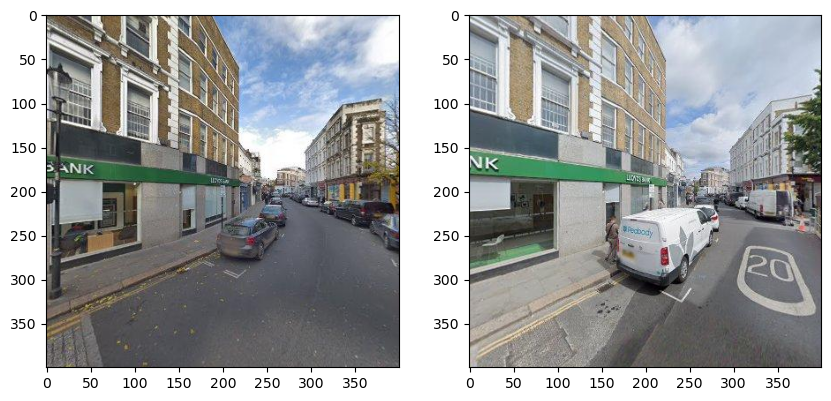

In [52]:

index = 28
sample_A = validation.loc[index, 'A']
sample_B = validation.loc[index, 'B']
# get image encoding from df
img_A = df_sel_angle[(df_sel_angle['panoid'] == sample_A)]['img_encoding'].values[0]
img_B = df_sel_angle[(df_sel_angle['panoid'] == sample_B)]['img_encoding'].values[0]
sample_improve = [f for f in improve_fields if validation.loc[index, f] == 1]
sample_decline = [f for f in decline_fields if validation.loc[index, f] == -1]
print("Improved: ", ", ".join(sample_improve))
print("Declined: ", ", ".join(sample_decline))

# plot image side by side
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(get_image(img_A))
ax[1].imshow(get_image(img_B))

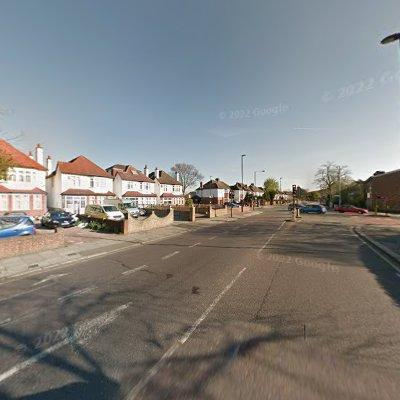

In [146]:
base64_image_A, panoid_A, base64_image_B, panoid_B = get_param(df_sel_angle_current, sample_h3)
Image.open(BytesIO(base64.urlsafe_b64decode(base64_image_A))).convert("RGB")

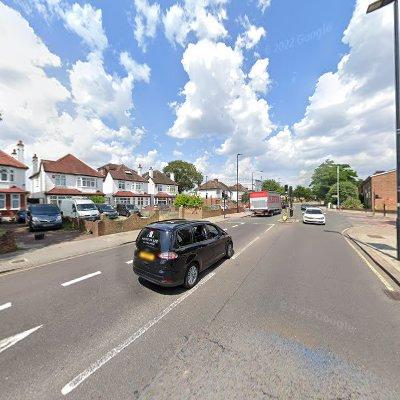

In [147]:
Image.open(BytesIO(base64.urlsafe_b64decode(base64_image_B))).convert("RGB")